## Using Keras to build a recommender system with collaborative filtering

In [ ]:
#option 2
from google.colab import drive
drive.mount('/content/drive/')

#option 3
from google.colab import files
files.upload() #load file from stored location 

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import csv

ratings = pd.read_csv('/content/drive/MyDrive/rating.csv', engine ='python') #dataset is from the "movielens" data from kaggle
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [ ]:
#For collaborative filtering, we need user/movie fields to be sequential starting at zero to use for modeling
#They are currently non-sequential integers representing some unique ID for that entity. 
#Use label encoder to transform the fields

user_enc = LabelEncoder()
ratings['user'] = user_enc.fit_transform(ratings['userId'].values)
n_users = ratings['user'].nunique()

item_enc = LabelEncoder()
ratings['movie'] = item_enc.fit_transform(ratings['movieId'].values)
n_movies = ratings['movie'].nunique()

ratings['rating'] = ratings['rating'].values.astype(np.float32)
min_rating = min(ratings['rating'])
max_rating = max(ratings['rating'])

n_users, n_movies, min_rating, max_rating

(138493, 26744, 0.5, 5.0)

In [ ]:
#split data into train/test datasets
X = ratings[['user', 'movie']].values
y = ratings['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((18000236, 2), (2000027, 2), (18000236,), (2000027,))

In [ ]:
#turn users and movies into separate arrays in the training and test data
#In keras each input is to be fed as its own array

n_factors = 50

X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [ ]:
#Define
#Input: Input for both movies & users
#Embedding Layers: Embeddings for movies & users
#Dot: combines embeddings using a dot product
#the embeddings are the weights that are learned during training
#use embeddings to represent each user and each movie in the data. These embeddings will be vectors (of size n_factors) 

from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2
def RecommenderV1(n_users, n_movies, n_factors):
    user = Input(shape=(1,))
    u = Embedding(n_users, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
    u = Reshape((n_factors,))(u)
    
    movie = Input(shape=(1,))
    m = Embedding(n_movies, n_factors, name="Movie-Embedding", embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(movie)
    m = Reshape((n_factors,))(m)
    
    x = Dot(axes=1)([u, m]) #compute the dot product between a user vector and a movie vector to get a predicted rating
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [ ]:
model = RecommenderV1(n_users, n_movies, n_factors)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 50)        6924650     input_1[0][0]                    
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 50)        1337200     input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
#may consume large amount of memory
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=1, verbose=1, validation_data=(X_test_array, y_test))

281254/281254 [==============================] - 18425s 66ms/step - loss: 3.4743 - val_loss: 2.1821


In [ ]:
model.save('recommender_model.h5')

## Visualize embeddings

In [ ]:
#you can use embeddings to visualize relations between movies. This requires dimensionality reduction
# Extract embeddings
movie_em = model.get_layer('Movie-Embedding')
movie_em_weights = movie_em.get_weights()[0]

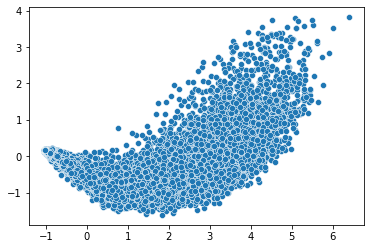

In [ ]:
#visualize the embeddings
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2) # startinf with 10000 dimensions, map to 2 dimensions
pca_result = pca.fit_transform(movie_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [ ]:
movies = pd.read_csv("/content/movie.csv")
movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
